# CONTEXTE DE NOTRE ETUDE
Les séries temporelles sont utilisées dans de nombreux domaines tels que l’astronomie et la météorologie, et sont probablement le plus utilisées en économie. 
On peut penser, par exemple, au cours des actions des entreprises ou encore à l’évolution des températures au cours du temps, l'évolution des ventes au fil du temps.

I- IMPORTATION DES PACKAGES

In [2]:
# 1. Import des bibliothèques
# =========================================
import tensorflow as tf
import os
import statsmodels.api as sm
import sklearn
import numpy as np
import pandas as pd
import pymannkendall as mk
import matplotlib.pyplot as plt
import plotly
import random
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

 IMPORTATION ET PREPARATION DU JEU DE DONNEES

In [3]:
PuisMod= pd.read_excel('C:/Users/ELITEBOOK/Projet2025/Puissancehoraire.xlsx')
PuisMod.rename(columns={PuisMod.columns[0]: "date"}, inplace=True)# Renommer la première colonne
PuisMod.head(10)# affichage des 10 premières lignes
PuisMod.isna().sum()
#PuisMod.shape

date        0
00:00:00    0
01:00:00    0
02:00:00    0
03:00:00    0
04:00:00    0
05:00:00    0
06:00:00    0
07:00:00    0
08:00:00    0
09:00:00    0
10:00:00    0
11:00:00    0
12:00:00    0
13:00:00    0
14:00:00    0
15:00:00    0
16:00:00    0
17:00:00    1
18:00:00    0
19:00:00    0
20:00:00    0
21:00:00    0
22:00:00    0
23:00:00    0
dtype: int64

In [4]:
PuisMod = pd.DataFrame(PuisMod)
# On remarque que dans la colonne de 17, il y a une valeur manquante sur les 2191 lignes valeur que nous allons corriger avec la 
# médiane des données collectée dans cette colonne
PuisMod.fillna(PuisMod[['17:00:00']].median(),inplace = True)
####################################
#PuisMod.isna().sum()# nous avons corriger la valeur manquante

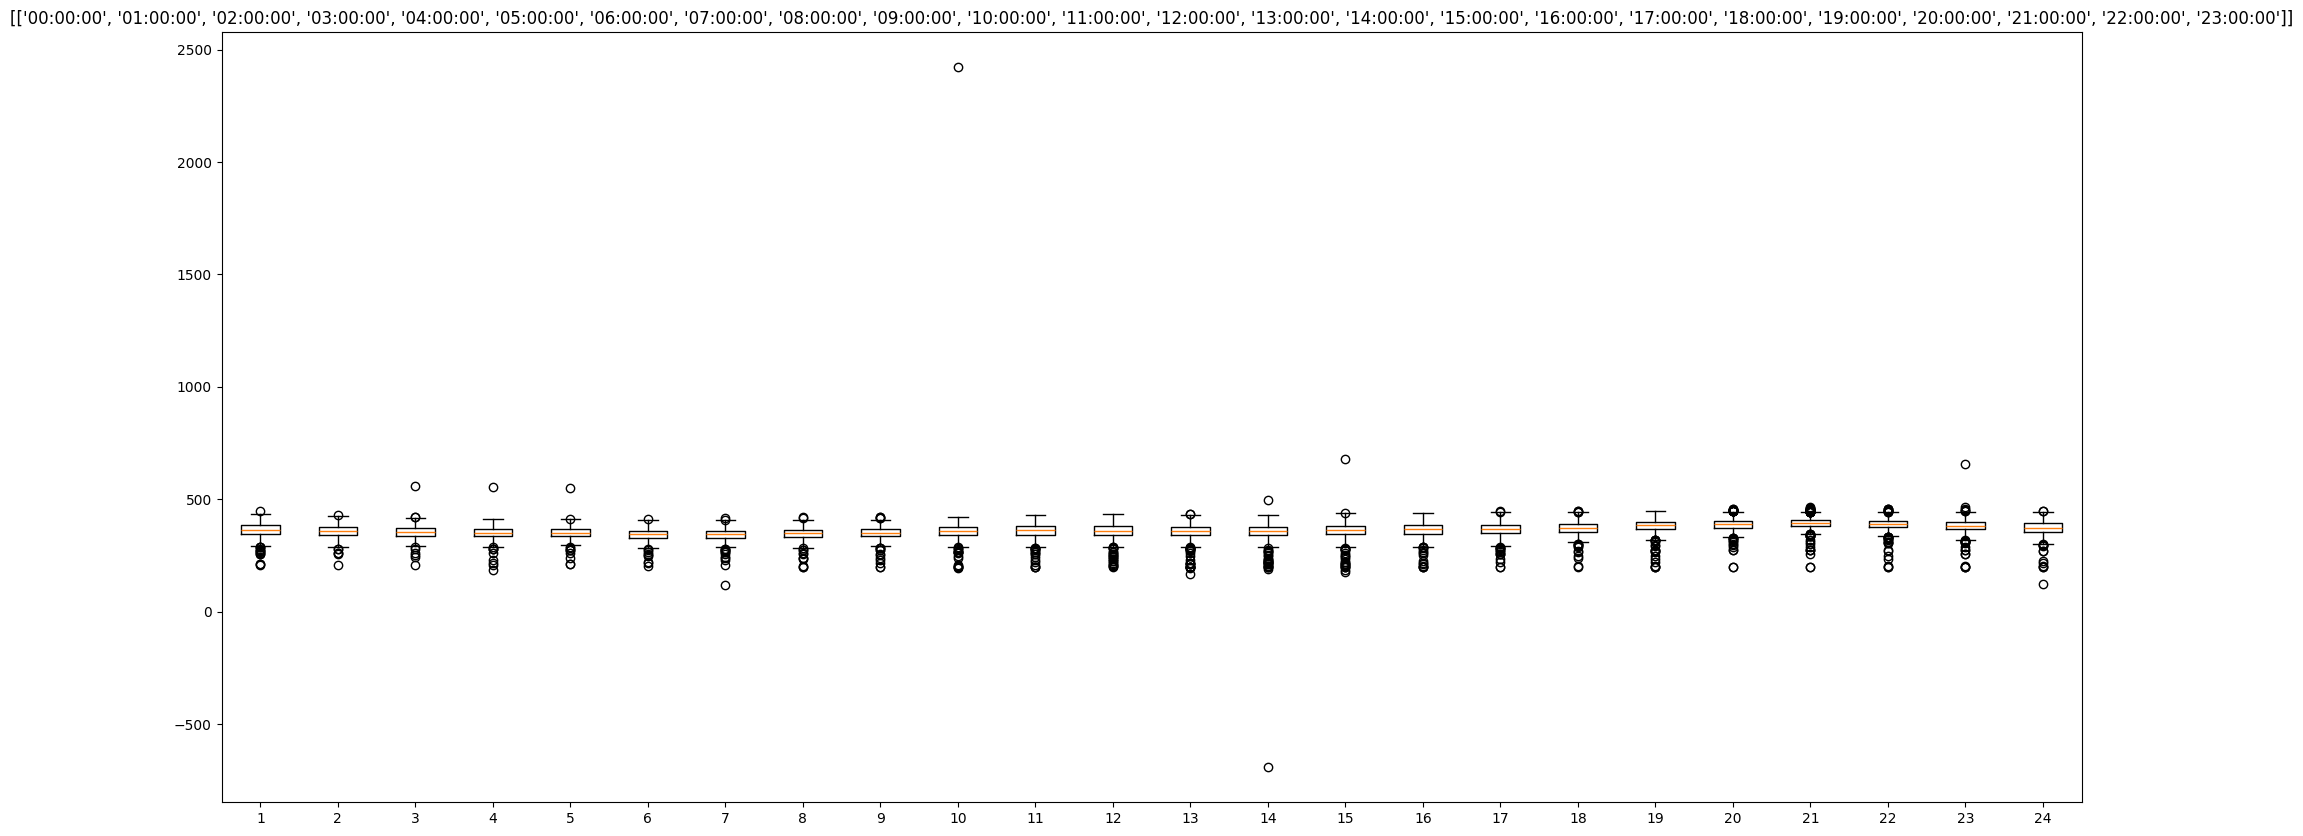

In [5]:
########### Recherche des outliner
#PuisMod = np.array(PuisMod)
#plt.boxplot(PuisMod['00:00:00'])
plt.figure(figsize=(24, 10))
col= [['00:00:00', '01:00:00', '02:00:00', '03:00:00', '04:00:00',
       '05:00:00', '06:00:00', '07:00:00', '08:00:00', '09:00:00', '10:00:00',
       '11:00:00', '12:00:00', '13:00:00', '14:00:00', '15:00:00', '16:00:00',
       '17:00:00', '18:00:00', '19:00:00', '20:00:00', '21:00:00', '22:00:00',
       '23:00:00']]
for i in col:
    plt.boxplot(PuisMod[i])
    plt.title(col)
    plt.show()

In [6]:
#CORRECTION DE LA VALEUR ABBERANTES AU NIVEAU DE 09 HEURE
Q1_09= np.quantile(PuisMod['09:00:00'], 0.25)
Q3_09= np.quantile(PuisMod['09:00:00'], 0.75)
IQR_09 = Q3_09-Q1_09
Max_09= Q3_09 +(1.5*IQR_09)
################## 
#CORRECTION DE LA VALEUR ABBERANTES AU NIVEAU DE 14 HEURE
Q1_13= np.quantile(PuisMod['13:00:00'], 0.25)
Q3_13= np.quantile(PuisMod['13:00:00'], 0.75)
IQR_13 = Q3_13-Q1_13
MIN_13= Q1_13 -(1.5*IQR_13)

In [7]:
# RECHERCHE DE L'INDEXE OU 09 Heure est trop élevé
Aber= PuisMod['09:00:00'].idxmax()
Abermin= PuisMod['13:00:00'].idxmin()
PuisMod.loc[Aber, '09:00:00']= Max_09
PuisMod.loc[Abermin, '13:00:00']= MIN_13

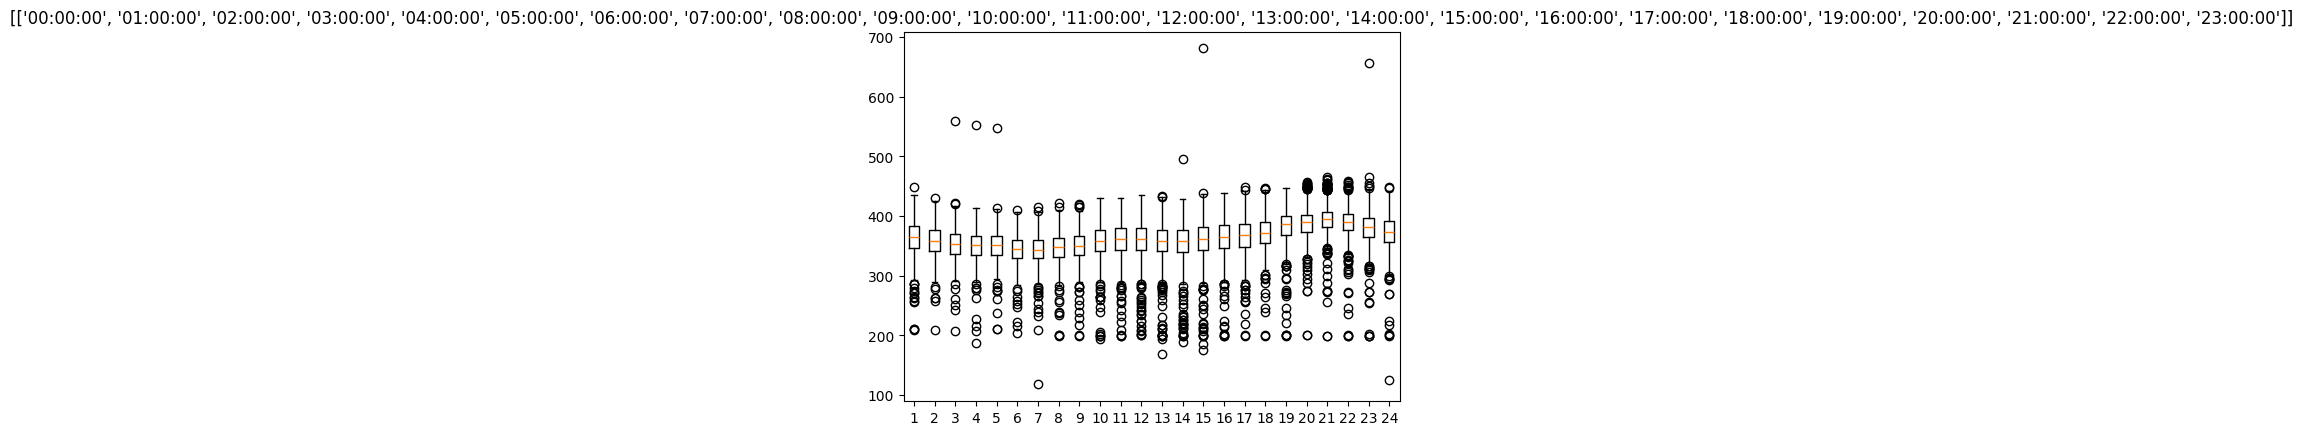

In [8]:
for i in col:
    plt.boxplot(PuisMod[i])
    plt.title(col)
    plt.show()
    

On remarque que la valeur extrême de 2000 a été corrigée et même la valeur négative a été corrigée. 
Nous les avons corrigées en calculant les valeurs maximales et minimales auxquelles on pouvait s'attendre sur la base de la données enregistrées pour chaque heure.

Text(0, 0.5, 'Consommation (somme des 24h)')

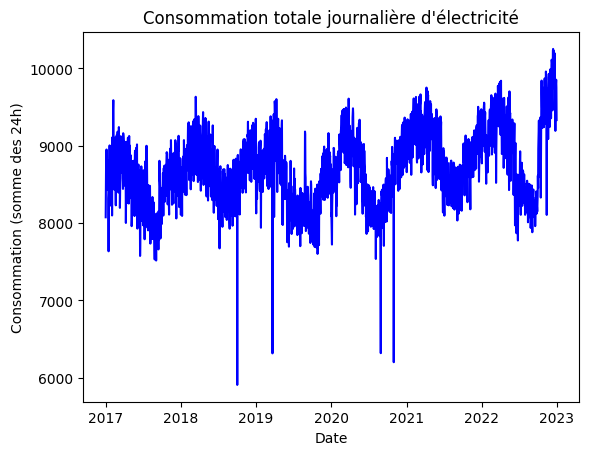

In [9]:
PuisMod["somme_journalière"] = PuisMod.iloc[:, 1:25].sum(axis=1)
# Tracé de la ligne
plt.plot(PuisMod["date"], PuisMod["somme_journalière"], color="blue")
plt.title("Consommation totale journalière d'électricité")
plt.xlabel("Date")
plt.ylabel("Consommation (somme des 24h)")

In [10]:
#Conso_semaine= PuisMod["somme_journalière"] 
PuisMod= PuisMod.drop("somme_journalière",axis=1)

In [11]:
# Transformation en format long du jeu de données
Puislong= pd.melt(PuisMod, id_vars="date", var_name="Heure", value_name="Consommation")
Puislong['Datetime'] = pd.to_datetime(
    Puislong['date'].astype(str) + ' ' + Puislong['Heure'].astype(str))
Puislong

,date,Heure,Consommation,Datetime
0,2017-01-01,00:00:00,335.292319,2017-01-01 00:00:00
1,2017-01-02,00:00:00,326.410170,2017-01-02 00:00:00
2,2017-01-03,00:00:00,352.965537,2017-01-03 00:00:00
3,2017-01-04,00:00:00,359.879849,2017-01-04 00:00:00
4,2017-01-05,00:00:00,366.070516,2017-01-05 00:00:00
...,...,...,...,...
52579,2022-12-27,23:00:00,429.352812,2022-12-27 23:00:00
52580,2022-12-28,23:00:00,436.544665,2022-12-28 23:00:00
52581,2022-12-29,23:00:00,436.197404,2022-12-29 23:00:00
52582,2022-12-30,23:00:00,426.433755,2022-12-30 23:00:00


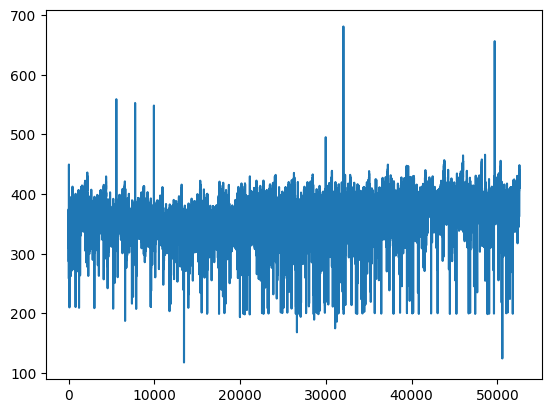

In [12]:
# Représenation graphique

plt.plot(Puislong['Consommation'])

In [13]:
#pd.Series(Puislong["Consommation"]).plot(kind="bar", width=50)
#plt.show()

III- MODELISATION DES DONNEES

# a- TESTONS LA STATIONNARITE DE NOTRE JEU DE DONNEE
Pour faire le test de stationnarité de notre série, nous avons plusieurs test qui peuvent nous permettre
de le réaliser dont le test de Dickey-Fuller qui nous donne de bons résultats rapidement et est déjà implémenté dans Python dans la librairie Statsmodels.

In [12]:
# Jeu de donnée pour faire la stationnarité, la décomposition et le test de dickey Fuller

df=Puislong[['Consommation','Datetime']]
df = df.set_index('Datetime').sort_index()
print(df.head())


                     Consommation
Datetime                         
2017-01-01 00:00:00    335.292319
2017-01-01 01:00:00    366.188139
2017-01-01 02:00:00    344.493160
2017-01-01 03:00:00    347.964323
2017-01-01 04:00:00    347.877341


In [13]:
# TEST LA STATIONNARITE DE NOTRE SERIE CHRONOLOGIQUE
result = adfuller(df)
print('ADF Statistic:', result[0])
print('p-value:', result[1])
print('Nombre de retards utilisés:', result[2])
print('Nombre d’observations utilisées:', result[3])
print('Valeurs critiques:')

ADF Statistic: -13.139522072038353
p-value: 1.4389540068952707e-24
Nombre de retards utilisés: 58
Nombre d’observations utilisées: 52525
Valeurs critiques:


Interprètation
ADF Statistic: -13.137476103707504(C’est la valeur de la statistique de test. Plus elle est négative, plus il est probable que la série soit stationnaire.)
p-value:1.4521720918088898e-24, la p_value est très petite, on ne rejette l’hypothèse nulle. Ce résultat pourrait nous consduire à dire que la serie est stationnaire au seuil de 5% .
Nombre de retards utilisés: 58
Nombre d’observations utilisées: 52525
Conclusion:
P-value aussi faible; statistique ADF très négative, nous avons de bonnes raisons de conclure que la série est stationnaire au niveau de confiance classique (95%). Mais nous allons pas conclure directement, nous faire des tests complémentaires pour sûre de ce que nous allons conclure.

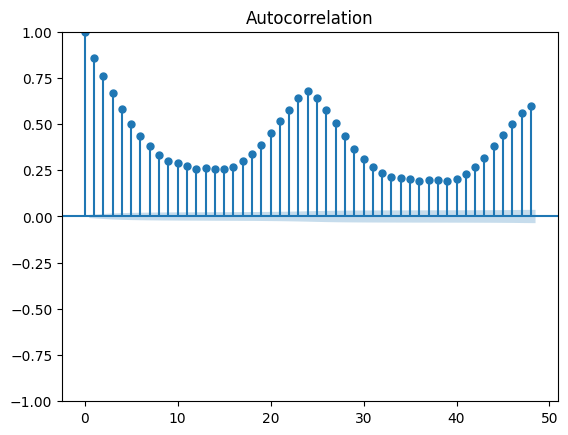

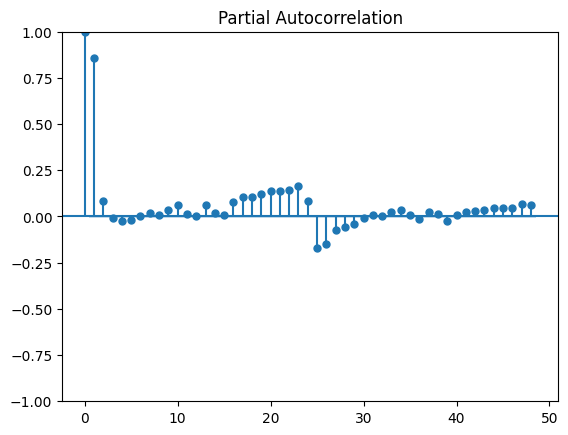

In [14]:
# Réalisons le graphe de l'ACF pour observer si elle aussi confirme la stationnarité
sm.graphics.tsa.plot_acf(df)
sm.graphics.tsa.plot_pacf(df)
plt.show()

# COMMENTAIRES
Le premier graphe représente le tracé de l'ACF:
On observe:
Décroissance Lente : les coefficients d'autocorrélation chutent lentement à zéro (de 1.0 à 0.77, 0.68, etc.). Cette décroissance lente est un indicateur fort que votre série temporelle n'est pas stationnaire. Une série stationnaire a des propriétés statistiques qui ne changent pas avec le temps, elle est constante dans le temps et l' ACF après le lag 1 se rapproche rapidement de zéro. Ce qui n'est pas le cas ici.
b- Saisonnalité Prononcée : Après une décroissance initiale, les coefficients remontent de manière significative (18 à 24 avec un pic important à 0.619 ) deuxième monté de de 39 à 27 qui culmine à 0.509 au décalage 47 (près de 24 * 2). L'observatiion des pics réguliers et prononcés indique une forte saisonnalité dans les données. Le pic à 24, nous ressort une saisonnalité de 24 heure de temps qui se répète dans nos donnés.
Hypoyhèse:
Modèle AR : Le pic important et la décroissance rapide des premiers termes de la PACF suggèrent un modèle autorégressif d'ordre p=1 (AR(1)). Le coefficient d'autocorrélation partielle à lag 1 est très élevé, ce qui signifie que l'observation actuelle est fortement et directement liée à l'observation précédente.
Saisonnalité : Le pic à lag 24 dans la PACF, combiné au pic de l'ACF, indique un modèle saisonnier. La PACF s'éteint après le lag 24, ce qui suggère un paramètre saisonnier P dans un modèle SARIMA.

Conclusion: Les résultats des tracés de l'ACF et du PACF  ne viennent pas confirmer ce qui s'observe au niveau du test de ADF. alors nous allons réaliser le test de KPSS pour nous départager.

In [15]:
# TEST DE KPSS
#Hypothèse nulle (H₀) : la série est stationnaire.
#Kpss  p-value < 0.05, alors on  rejette H₀: série non stationnaire.
from statsmodels.tsa.stattools import kpss
stationnaire = kpss(df)
print('KPSS Statistic:', stationnaire[0])
print('p-value:', stationnaire[1])
print('Nombre de retards utilisés:', stationnaire[2])
print('Nombre d’observations utilisées:', stationnaire[3])
print('Valeurs critiques:')

KPSS Statistic: 6.416509211073197
p-value: 0.01
Nombre de retards utilisés: 114
Nombre d’observations utilisées: {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}
Valeurs critiques:


C:\Users\ELITEBOOK\AppData\Local\Temp\ipykernel_56884\843744663.py:5: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  stationnaire = kpss(df)


La p-value étant inférieur à 5%, la p-value du test de Kpss vient confirmer que notre série n'est pas stationnaire comme l'ont montré l'ACF et le PACF

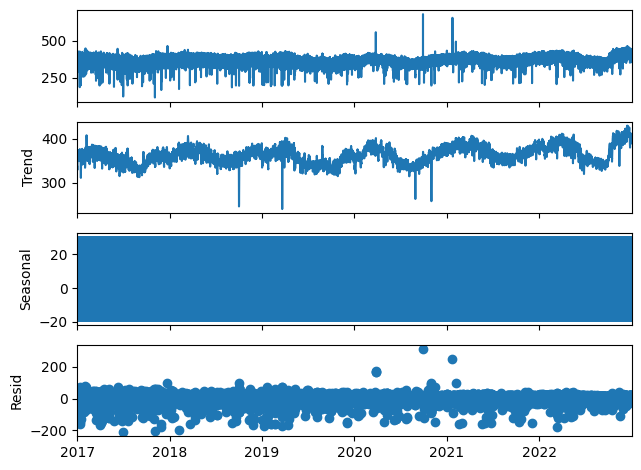

In [16]:
# Décomposition de la série
decompose_result = seasonal_decompose(df, model='additive', period=24)
# Affichage
decompose_result.plot()
plt.show()

COMMENTAIRE
A ce niveau, vous pouvez tester les modèles ARIMA, SARIMA, nous n'avons pas fait le choix du modèle
ARMA car nous avons remarqué que notre série n'est pas stationnaire, donc pour continuer, on aura à différencier la série. 
En plus du phénomène de saisonnalité que nous avons observé lors du tracé des graphiques de l'ACF et PACF, nous avons fait l'option d'utiliser un modèle sarima.

In [33]:
#Présentation du modèle SARIMA
# SARIMA(p,d,q)(P,D,Q,s)
order = (0, 1, 3)       # partie non saisonnière (p,d,q)
seasonal_order = (2, 0, 0, 24)  # partie saisonnière (P,D,Q,s)

#  le modèle appliqué sur nos données
sarima = SARIMAX(df['Consommation'], order=order, seasonal_order=seasonal_order, enforce_stationarity=False, enforce_invertibility=False)
#results = sarima.fit()
#print(results.summary())


C:\Users\ELITEBOOK\anaconda3\envs\EnvDeepLearning\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
C:\Users\ELITEBOOK\anaconda3\envs\EnvDeepLearning\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)


In [34]:
results = sarima.fit()
print(results.summary())
# Faire le SARIMAX sur les données horaires si la capacité de votre ordinateur vous le permet sinon vous pouvez aggréger 
#les données en jours pour le faire


                                      SARIMAX Results                                      
Dep. Variable:                        Consommation   No. Observations:                52584
Model:             SARIMAX(0, 1, 3)x(2, 0, [], 24)   Log Likelihood             -212163.366
Date:                             Fri, 29 Aug 2025   AIC                         424338.732
Time:                                     16:46:11   BIC                         424391.947
Sample:                                 01-01-2017   HQIC                        424355.363
                                      - 12-31-2022                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.3584      0.001   -284.505      0.000      -0.361      -0.356
ma.L2         -0.0722      


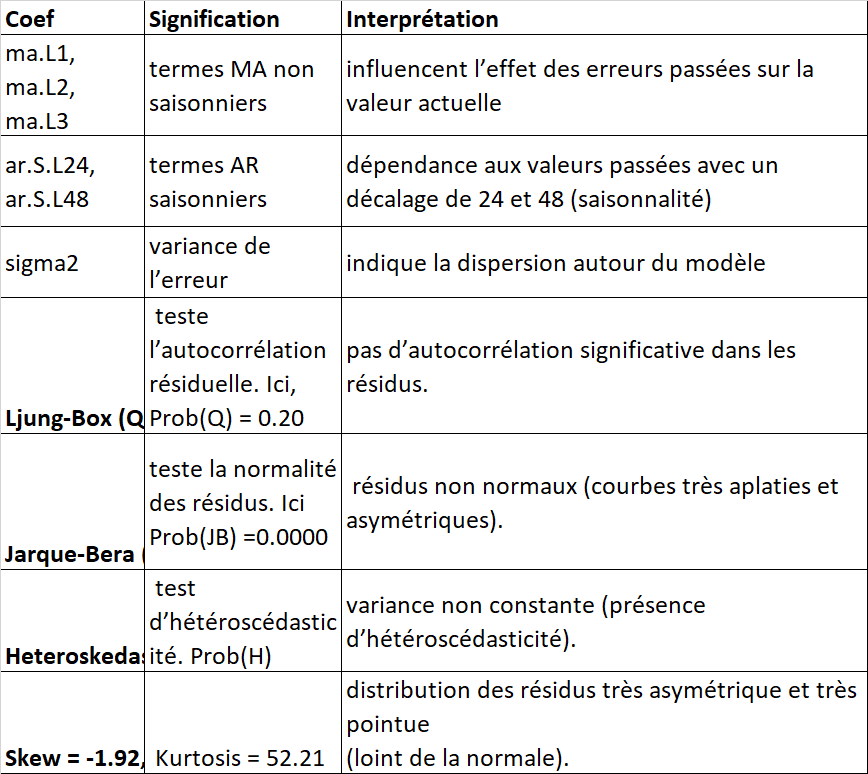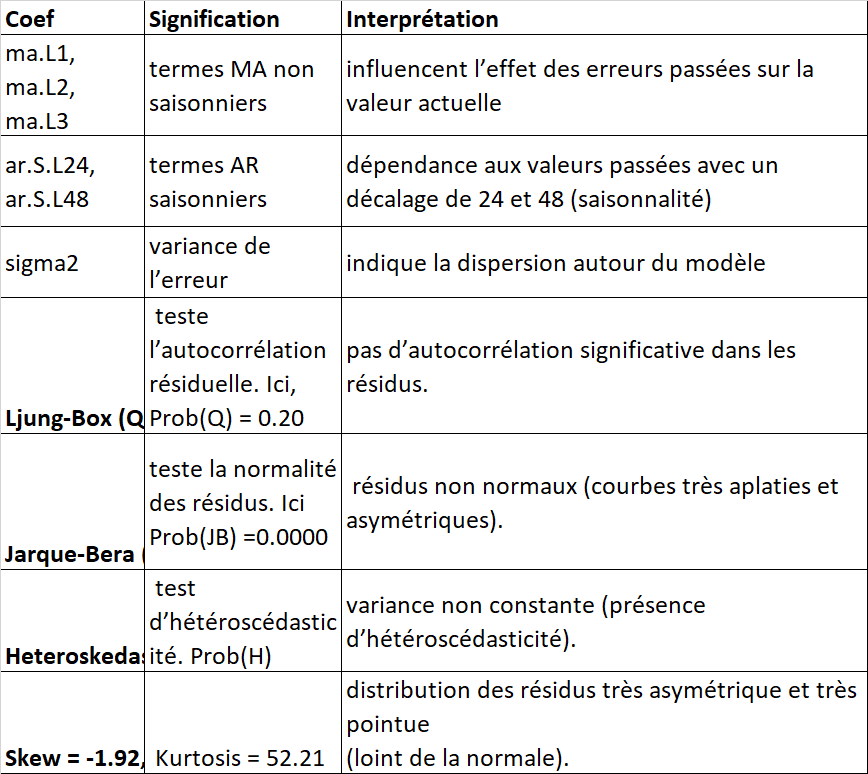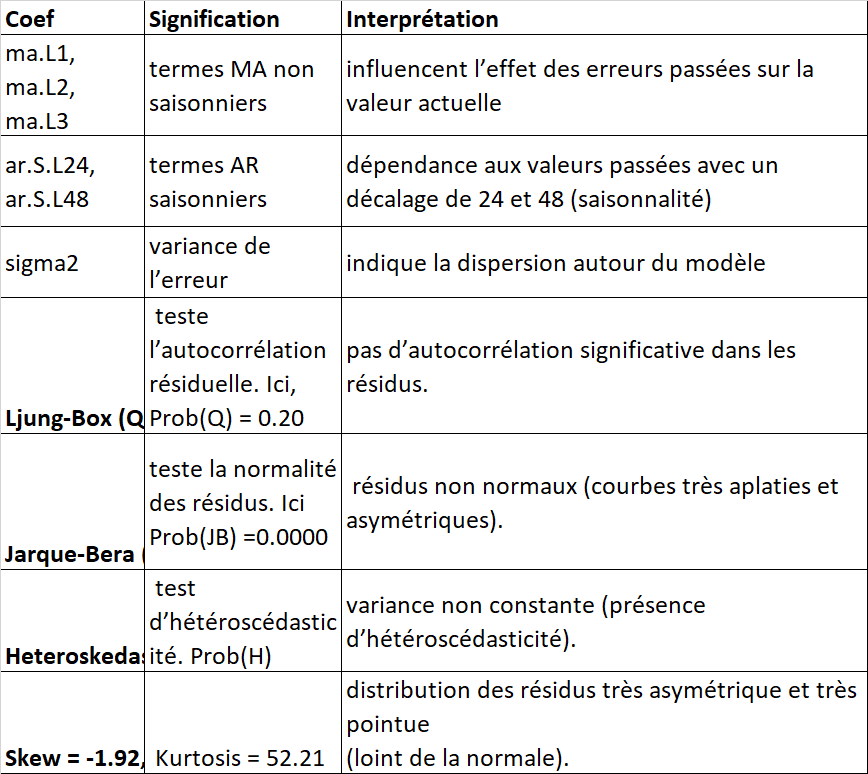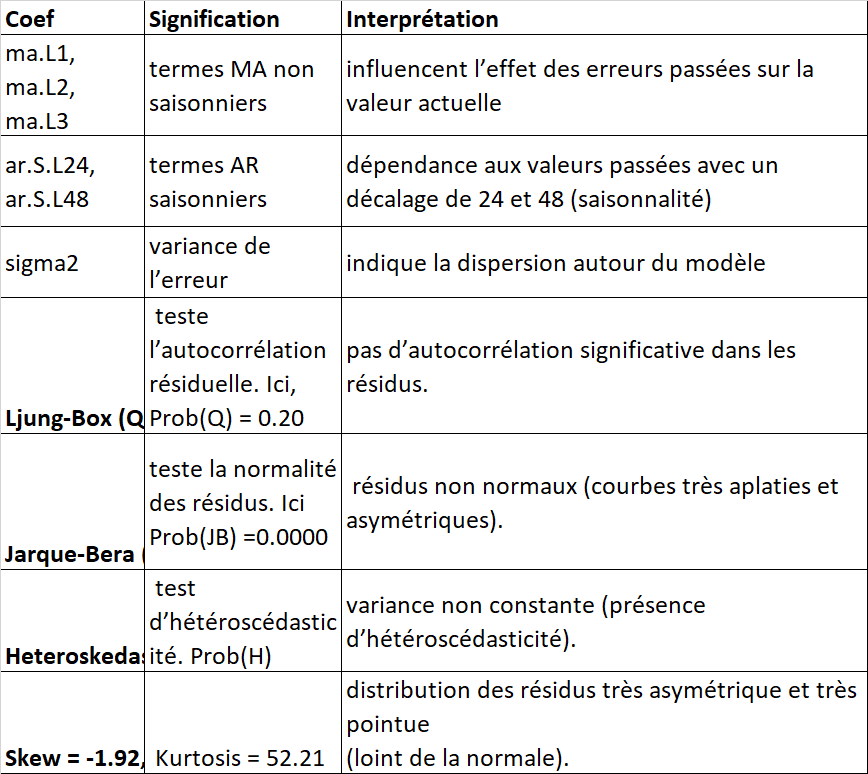

Concluison : Résidus non-normaux, Variance non constance, alors les erreurs de ce modèle ne sont pas de type bruit blanc, nous ne pouvons pas alors généraliser ce modèle pour faire de la prédiction. Nous avons allons penser à utiliser le modèle LSTM pour prédire la consommation d'énergie.

In [ ]:
# CE CODE est pour au cas où le sarima sur les données horaires
#n'aboutit pas sur vos vos données à cause de la taille des données pour 
#pouvez agréger les données en jours.

# Données aggrées en jour pour faire le SARIMAX
#random.seed()
#df_jour = df['Consommation'].resample('D').sum()
#sarima = SARIMAX(df_jour, order=(0,1,3), seasonal_order=(2,0,0,7),  # périodicité = 7 jours
#                 enforce_stationarity=False, enforce_invertibility=False)
#results = sarima.fit(disp=False)
#print(results.summary())

# MODELE LSTM SUR LES DONNEES HORAIRES

In [17]:
Consommation= Puislong[['Consommation']]
Consommation

,Consommation
0,335.292319
1,326.410170
2,352.965537
3,359.879849
4,366.070516
...,...
52579,429.352812
52580,436.544665
52581,436.197404
52582,426.433755


In [18]:
#Pour faire le LSTM, il est nécessaire de normaliser les données
scaler = MinMaxScaler(feature_range=(0, 1))# Pour la normalisation

In [22]:
# 3. Préparation des données pour LSTM
data_scaled = scaler.fit_transform(Consommation)

# Fonction pour créer des séquences
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)

SEQ_LENGTHS = [24, 48, 72, 96, 120, 144, 168]  # 1 jour, 2 jours, 3 et 7 jours d'historique

######################## Les datasets pour chaque sequence (pour chaque sequence, créer les X, y correspondantes 
# et consigne les dans datasets
datasets = {}
for seq_len in SEQ_LENGTHS:
    X, y = create_sequences(data_scaled, seq_len)
    X = X.reshape((X.shape[0], X.shape[1], 1))  # reshape pour LSTM
    datasets[seq_len] = (X, y)
    

In [24]:
# Séparation du jeu de donnée
random.seed(42) # pour fixer l'aléa
train_size = int(len(data_scaled)*0.8)
train, test = data_scaled[:train_size], data_scaled[train_size:]
X_train, y_train = create_sequences(train, seq)
X_test, y_test = create_sequences(test, seq)

In [46]:

## La boucle pour parcourrir les différentes séquences
results = {}
SEQ_LENGTHS = [24, 48, 72, 96, 120, 144, 168] 
for seq in SEQ_LENGTHS:
    print(f"\n Test avec séquence = {seq}")
    # les séquences
    X_train, y_train = create_sequences(train, seq)
    X_test, y_test = create_sequences(test, seq)

    # Redéfinissons les dimensions variables pour le modèle LSTM
    X_train = X_train.reshape((X_train.shape[0],X_train.shape[1],1))
    X_test = X_test.reshape((X_test.shape[0],X_test.shape[1],1))

    # Maintenant définissons le modèle LSTM
    model= Sequential([
           LSTM(50, activation='tanh', input_shape=(seq,1)),
           Dense(1)
])
    model.compile(optimizer='adam', loss='mse')
    #  Entraînons le modèle
    model.fit(X_train, y_train, epochs=10, batch_size=32, verbose=0)

     # Évaluation du modèle
    y_pred = model.predict(X_test, verbose=0)
    mse = mean_squared_error(y_test, y_pred)
    
    # Stocker le résultat
    results[seq] = mse
    print(f"MSE = {mse:.4f}")

# Résultat final
print("\n Résumé des performances :")
for seq, mse in results.items():
    print(f"seq_length={seq} --> MSE={mse:.4f}")


 Test avec séquence = 24


C:\Users\ELITEBOOK\anaconda3\envs\EnvDeepLearning\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


MSE = 0.0008

 Test avec séquence = 48


C:\Users\ELITEBOOK\anaconda3\envs\EnvDeepLearning\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


MSE = 0.0008

 Test avec séquence = 72


C:\Users\ELITEBOOK\anaconda3\envs\EnvDeepLearning\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


MSE = 0.0007

 Test avec séquence = 96


C:\Users\ELITEBOOK\anaconda3\envs\EnvDeepLearning\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


MSE = 0.0009

 Test avec séquence = 120


C:\Users\ELITEBOOK\anaconda3\envs\EnvDeepLearning\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


MSE = 0.0008

 Test avec séquence = 144


C:\Users\ELITEBOOK\anaconda3\envs\EnvDeepLearning\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


MSE = 0.0008

 Test avec séquence = 168


C:\Users\ELITEBOOK\anaconda3\envs\EnvDeepLearning\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


MSE = 0.0008

 Résumé des performances :
seq_length=24 --> MSE=0.0008
seq_length=48 --> MSE=0.0008
seq_length=72 --> MSE=0.0007
seq_length=96 --> MSE=0.0009
seq_length=120 --> MSE=0.0008
seq_length=144 --> MSE=0.0008
seq_length=168 --> MSE=0.0008


COMMENTAIRE SUR LES RESULTATS
Le meilleur score (MSE ≈ 0.0007) est obtenue avec seq_length= 72.

In [25]:
# Le modèle LSTM pour une sortie T+1
# Pour continuer, nous allons prendre SEQ_LENGTH =72
seq=72
X_train, y_train = create_sequences(train, seq)
X_test, y_test = create_sequences(test, seq)

SEQ_LENGTH =72
model = Sequential([
    LSTM(50, activation='relu', input_shape=(SEQ_LENGTH, 1)),
    Dense(1)
])

model.compile(optimizer='adam', loss='mse')
model.summary()

C:\Users\ELITEBOOK\anaconda3\envs\EnvDeepLearning\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_1 (LSTM)                        │ (None, 50)                  │          10,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 10,451 (40.82 KB)

 Trainable params: 10,451 (40.82 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
2625/2625 ━━━━━━━━━━━━━━━━━━━━ 61s 23ms/step - loss: 0.0018 - val_loss: 7.8288e-04
Epoch 2/20
2625/2625 ━━━━━━━━━━━━━━━━━━━━ 60s 23ms/step - loss: 0.0013 - val_loss: 7.7392e-04
Epoch 3/20
2625/2625 ━━━━━━━━━━━━━━━━━━━━ 61s 23ms/step - loss: 0.0012 - val_loss: 9.4523e-04
Epoch 4/20
2625/2625 ━━━━━━━━━━━━━━━━━━━━ 62s 24ms/step - loss: 0.0011 - val_loss: 8.1494e-04
Epoch 5/20
2625/2625 ━━━━━━━━━━━━━━━━━━━━ 60s 23ms/step - loss: 0.0010 - val_loss: 7.5313e-04
Epoch 6/20
2625/2625 ━━━━━━━━━━━━━━━━━━━━ 62s 24ms/step - loss: 9.3571e-04 - val_loss: 8.0899e-04
Epoch 7/20
2625/2625 ━━━━━━━━━━━━━━━━━━━━ 60s 23ms/step - loss: 8.9053e-04 - val_loss: 7.5082e-04
Epoch 8/20
2625/2625 ━━━━━━━━━━━━━━━━━━━━ 69s 26ms/step - loss: 9.3219e-04 - val_loss: 7.5351e-04
Epoch 9/20
2625/2625 ━━━━━━━━━━━━━━━━━━━━ 80s 30ms/step - loss: 8.8018e-04 - val_loss: 8.1578e-04
Epoch 10/20
2625/2625 ━━━━━━━━━━━━━━━━━━━━ 77s 29ms/step - loss: 8.6694e-04 - val_loss: 7.7519e-04
Epoch 11/20
2625/2625 ━━━━━━━━━━━━━━━━━

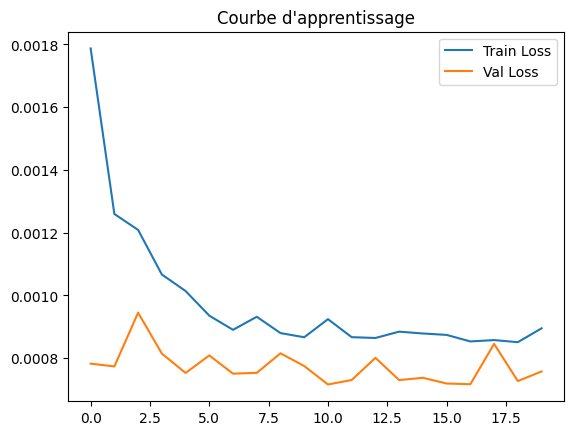

In [26]:
# 5. Entraînement
history = model.fit(X_train, y_train, epochs=20, batch_size=16,
                    validation_data=(X_test, y_test), verbose=1)

# 6. Évaluation
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.title("Courbe d'apprentissage")
plt.show() 

327/327 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step


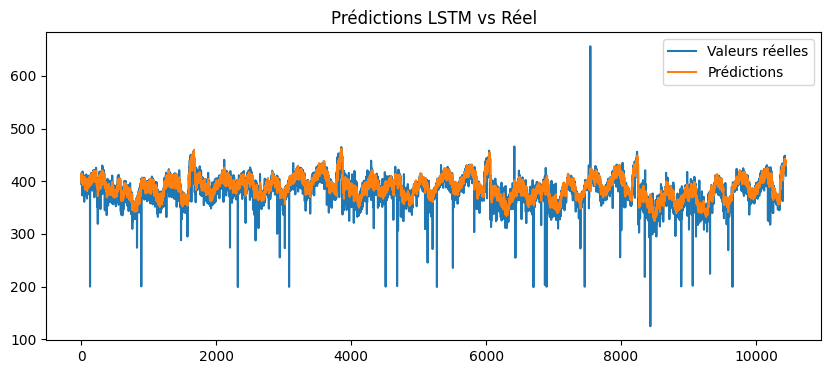

RMSE : 0.02752836133199176


In [27]:
# 7. Prédictions
# Vu que les données ont été normalisé avec de faire le modèle LSTM, Pour comparé la prédiction et 
# les valeurs test nous revenons au données non normalisée avec la fonction scaler.inverse_transform
y_pred = model.predict(X_test)
y_pred_inverse = scaler.inverse_transform(y_pred)
y_test_inverse = scaler.inverse_transform(y_test)

# Visualisation des prédictions vs valeurs réelles
plt.figure(figsize=(10,4))
plt.plot(y_test_inverse, label='Valeurs réelles')
plt.plot(y_pred_inverse, label='Prédictions')
plt.legend()
plt.title("Prédictions LSTM vs Réel")
plt.show()
###############################
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"RMSE : {rmse}")

In [28]:
loss_tr = model.evaluate(X_train, y_train)
loss_t = model.evaluate(X_test, y_test)
print(f"Loss (MSE) sur train : {loss_tr}")
print(f"Loss (MSE) sur test : {loss_t}")

1313/1313 ━━━━━━━━━━━━━━━━━━━━ 12s 9ms/step - loss: 8.8568e-04
327/327 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 7.5781e-04
Loss (MSE) sur train : 0.0008856764179654419
Loss (MSE) sur test : 0.0007578105432912707


COMMENTAIRE DES RESULTATS
Loss (MSE) sur train : 0.0010122775565832853
Loss (MSE) sur test : 0.0007747441413812339
On remarque que la perte sur test est légèrement plus basse que sur train, on peut alors dire que le modèle généralise bien(pas de phénomène de surapprentissage ni de sousapprentissage). 
Les erreurs sont très faibles ce qui est nomale car nos données ont été mis à échelle.
En conclusion, allons calculer le Rcarré pour voir la part de variabilité expliquée.

In [29]:
from sklearn.metrics import r2_score
R2= r2_score(y_test, y_pred)
R2#0.6149196770533589cela veut dire que le modèle capture environ 60% des données test ce qui 
#Donc à ce niveau nous pouvons déja dire que nous avons un bon modèle qui prédit la consommation de l'heure qui suit maintenant nous 
#aller à 24 heures de prédiction.

0.6212571945818993

In [31]:
# Nous allons à présent prédire les 24 prochaines heures
# Pour prédire les 24 prochaines heures, on va redéfenir la fonction sequence qui prends en compte les 24 prochaines heures

seq_length = 72 # 3 jours d'historiques
# On met n pour la fonction pour pouvoir varier la valeur de n par la suite.

def creat_sequences24 (data, seq_length, n):
    X, y = [], []
    for i in range(len(data) - seq_length-n+1):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length:i+seq_length+n])
    return np.array(X), np.array(y)

In [32]:
X2, y2 = creat_sequences24(data_scaled,seq_length=72, n=24)
# On reprends l'échantillon d'entrainement et de test sur les données en lui précisant que nous voulons une sortie de 24H
train_size = int(len(X2) * 0.8)
X2_train, X2_test = X2[:train_size], X2[train_size:]
y2_train, y2_test = y2[:train_size], y2[train_size:]
# On redéfinitle modèle LSTM car en haut on l'avait défini juste pour prédire une seule valeur, mais ici nous voulons prédire pour 24
model24 = Sequential([
    LSTM(96, activation='relu', input_shape=(SEQ_LENGTH, 1)),
    Dense(24)
])


model24.compile(optimizer='adam', loss='mse')
model24.summary()

#Entraînement
hist= model24.fit(X2_train, y2_train, epochs=10, batch_size=32, 
                    validation_data=(X2_test, y2_test), verbose=1)


C:\Users\ELITEBOOK\anaconda3\envs\EnvDeepLearning\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                        │ (None, 96)                  │          37,632 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 24)                  │           2,328 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 39,960 (156.09 KB)

 Trainable params: 39,960 (156.09 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 47s 34ms/step - loss: 0.0039 - val_loss: 0.0012
Epoch 2/10
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 46s 35ms/step - loss: 0.0014 - val_loss: 0.0013
Epoch 3/10
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 46s 35ms/step - loss: 0.0014 - val_loss: 0.0010
Epoch 4/10
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 47s 36ms/step - loss: 0.0014 - val_loss: 0.0011
Epoch 5/10
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 49s 37ms/step - loss: 0.0014 - val_loss: 0.0010
Epoch 6/10
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 49s 37ms/step - loss: 0.0014 - val_loss: 0.0011
Epoch 7/10
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 50s 38ms/step - loss: 0.0013 - val_loss: 0.0013
Epoch 8/10
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 48s 36ms/step - loss: 0.0012 - val_loss: 0.0010
Epoch 9/10
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 49s 37ms/step - loss: 0.0012 - val_loss: 0.0012
Epoch 10/10
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 49s 37ms/step - loss: 0.0012 - val_loss: 0.0011


In [35]:

# Prédire les 24 prochaines heures
# On travaille avec seq_length = 72
last_sequence = data_scaled[-seq_length:]# le modèle doit prendre les 72 valeurs passées
last_sequence = last_sequence.reshape(1,seq_length,1)# (1) une prédiction pour chaque heure, nombre de variables passée 48, 1:une seule variable explicative
predictions_scaled = model24.predict(last_sequence)# Sur la base des 72 dernières observations prédit les 24 prochaines heures.

# Inverser la normalisation
predictions = scaler.inverse_transform(predictions_scaled.reshape(-1,1))# ici c'est pour revenir aux données non normalisées

print("Prédiction pour t+1 à t+24:")# Affichage des 24 prédictions
print(predictions.flatten())


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step
Prédiction pour t+1 à t+24:
[413.21585 416.01212 420.51617 423.19492 421.13123 416.10812 411.4354
 406.34366 413.42404 417.95093 417.73856 419.26733 412.41208 404.22296
 404.12518 412.04736 416.73813 415.31555 416.82373 405.97818 403.80026
 396.186   405.5986  407.4605 ]


In [37]:
# EVALUATION DES PERFORMANCES DU MODELE DE PREDICTION DES 24 prochaines heures
predictions_scaled = model24.predict(X2_test)  # (n=24) et on a mis predictions_scaled, car X_test est normalisé
mse = mean_squared_error(y2_test.flatten(), predictions_scaled.flatten())
rmse = np.sqrt(mse)
R_a= r2_score(y2_test.flatten(), predictions_scaled.flatten())
print("MSE :", mse)
print("RMSE :", rmse)
print("R_carré:", R_a)

329/329 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step
MSE : 0.001101484378821181
RMSE : 0.0331886182119892
R_carré: 0.446980453508127


# COMMENTAIRE
On remarque que le R_carré de ceci est plus faibles que 
celui du modèle qui prédit juste l'heure qui suit. 
On peut aussi prendre l'option d'aggréger les données en jours et prédire pour plusieurs jours.

In [38]:
# Mettons nous avons aggréger les données en jours pour faire une prédiction sur plusieurs jours
df_jour = df['Consommation'].resample('D').sum()
df_jour

Datetime
2017-01-01    8075.594184
2017-01-02    8416.983542
2017-01-03    8827.971231
2017-01-04    8895.874285
2017-01-05    8951.426492
                 ...     
2022-12-27    9806.952746
2022-12-28    9809.275047
2022-12-29    9853.221791
2022-12-30    9754.670304
2022-12-31    9332.259054
Freq: D, Name: Consommation, Length: 2191, dtype: float64

In [39]:
# Normalisation des données
# Transformer la Series en tableau numpy 2D
series = df_jour.values.reshape(-1,1)

# Normalisation
series_scaled = scaler.fit_transform(series)
#series_scaled

In [40]:
# Ici on pouvait aussi faire la recherche de la meilleurs sequence mais ici on a sauté cette étape 
# car on l'avait déja fait plus haut sur les données horaires et donc vous pouvez le faire encore ici
# mais nous a choisi 72 jours
seq_length = 72  # longueur de la séquence 72 jours en arrières
horizon= 30
series_scaled = scaler.fit_transform(series.reshape(-1,1))  # normalisation
X3, y3 = creat_sequences24(series_scaled, seq_length,horizon)

# Ajustement de la forme de y (on veut (n_samples, 30))
y3 = y3.reshape(y3.shape[0], y3.shape[1])
print("Shape X:", X3.shape)  # (n_samples, 72, 1)
print("Shape y:", y3.shape)  # (n_samples, 30, 1)


# Split train/test
random.seed(42)
split = int(len(X3) * 0.8)
X3_train, X3_test = X3[:split], X3[split:]
y3_train, y3_test = y3[:split], y3[split:]


Shape X: (2090, 72, 1)
Shape y: (2090, 30)


In [41]:
model3 = Sequential([
    LSTM(96, activation='tanh', input_shape=(seq_length, 1)),
    Dense(30)  # prédiction de 30 jours
])

model3.compile(optimizer='adam', loss='mse')
model3.summary()

# ========= 3. Entraînement =========
Fut = model3.fit(X3_train, y3_train, epochs=30, batch_size=32, 
                    validation_split=0.1, verbose=1)

C:\Users\ELITEBOOK\anaconda3\envs\EnvDeepLearning\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_3 (LSTM)                        │ (None, 96)                  │          37,632 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 30)                  │           2,910 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 40,542 (158.37 KB)

 Trainable params: 40,542 (158.37 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
47/47 ━━━━━━━━━━━━━━━━━━━━ 3s 38ms/step - loss: 0.0782 - val_loss: 0.0045
Epoch 2/30
47/47 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - loss: 0.0081 - val_loss: 0.0039
Epoch 3/30
47/47 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - loss: 0.0075 - val_loss: 0.0038
Epoch 4/30
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0071 - val_loss: 0.0041
Epoch 5/30
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.0071 - val_loss: 0.0038
Epoch 6/30
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.0069 - val_loss: 0.0038
Epoch 7/30
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.0068 - val_loss: 0.0042
Epoch 8/30
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.0067 - val_loss: 0.0038
Epoch 9/30
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.0066 - val_loss: 0.0043
Epoch 10/30
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.0067 - val_loss: 0.0042
Epoch 11/30
47/47 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - loss: 0.0067 - val_loss: 0.0046
Epoch 12/30
47/47 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - loss: 0.0

14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step 


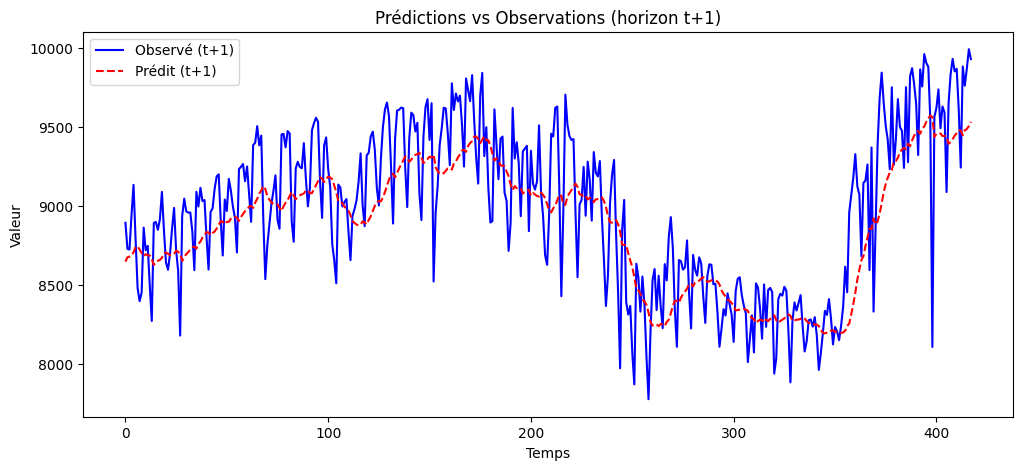

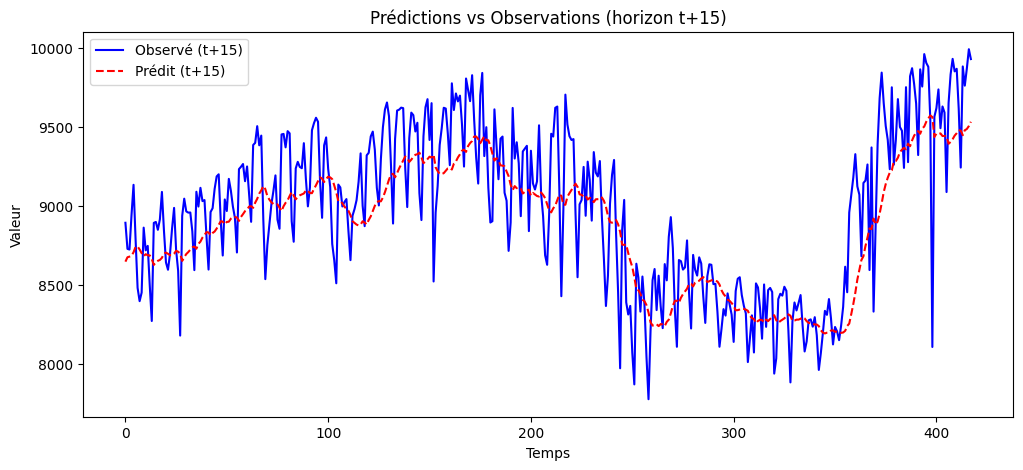

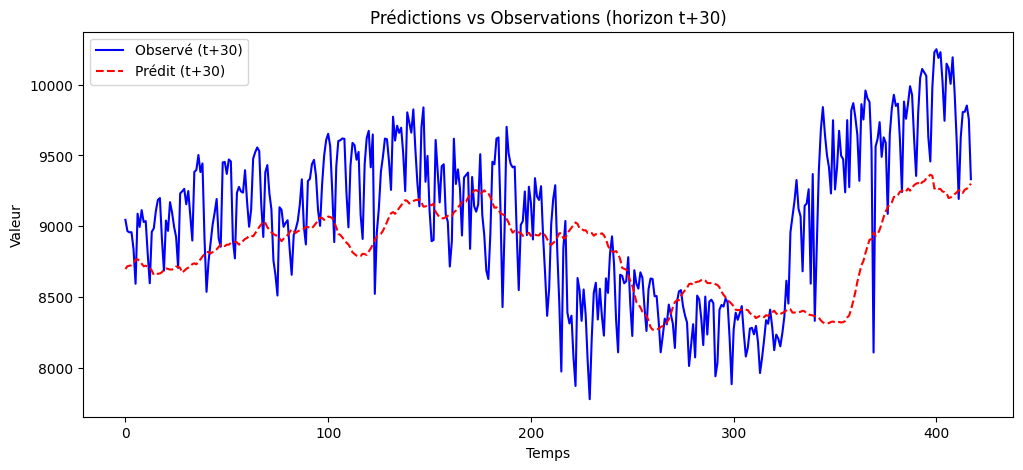

In [42]:

# 1. Prédiction
y_pred_scaled = model3.predict(X3_test)

# Comme nous avons normalisé les données, nous revons aux données de départ
y_test_inv = scaler.inverse_transform(y3_test.reshape(-1,1)).reshape(y3_test.shape)
y_pred_inv = scaler.inverse_transform(y_pred_scaled.reshape(-1,1)).reshape(y_pred_scaled.shape)

# 3. Tracé de t+1
plt.figure(figsize=(12,5))
plt.plot(y_test_inv[:,0], label="Observé (t+1)", color="blue")
plt.plot(y_pred_inv[:,0], label="Prédit (t+1)", color="red", linestyle="--")
plt.title("Prédictions vs Observations (horizon t+1)")
plt.xlabel("Temps")
plt.ylabel("Valeur")
plt.legend()
plt.show()

# 4. Tracé de t+15
plt.figure(figsize=(12,5))
plt.plot(y_test_inv[:,0], label="Observé (t+15)", color="blue")
plt.plot(y_pred_inv[:,0], label="Prédit (t+15)", color="red", linestyle="--")
plt.title("Prédictions vs Observations (horizon t+15)")
plt.xlabel("Temps")
plt.ylabel("Valeur")
plt.legend()
plt.show()

# 5. Tracé de t+30
plt.figure(figsize=(12,5))
plt.plot(y_test_inv[:,29], label="Observé (t+30)", color="blue")
plt.plot(y_pred_inv[:,29], label="Prédit (t+30)", color="red", linestyle="--")
plt.title("Prédictions vs Observations (horizon t+30)")
plt.xlabel("Temps")
plt.ylabel("Valeur")
plt.legend()
plt.show()


Voila on a ainsi les prédictions sur les 30 prochains jours et ici, nous avons pris historique de 48 jours.
On voit que pour le premier jour, le modèle prédit bien pour 15 jours également mais pour 30 jours, la prédiction est moins bonne.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


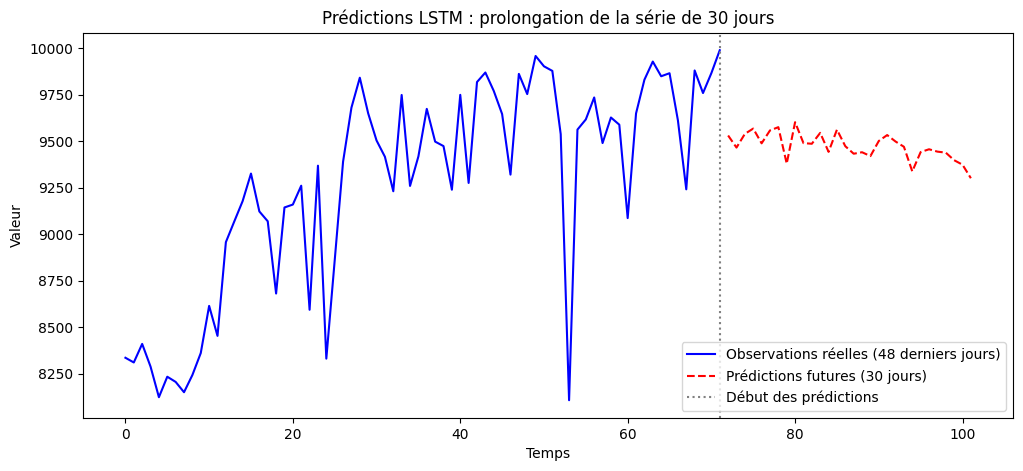

In [43]:

# 1. On prend la dernière séquence d'entrée ( 72 dernières observations)
last_sequence = X3_test[-1:]   # shape (1, 72, 1)

# 2. Prédiction des 30 prochains jours 
y_pred_scaled = model3.predict(last_sequence)

# 3. Inverse transform pour revenir aux vraies valeurs
last_obs = scaler.inverse_transform(last_sequence.reshape(-1,1))  # les 72 derniers jours observés
future_pred = scaler.inverse_transform(y_pred_scaled.reshape(-1,1))  # les 30 prochains jours prédits
# 4. Construction de la série complète : obs + prédictions
serie_complète = np.concatenate([last_obs, future_pred])
# 5. Tracé
plt.figure(figsize=(12,5))
plt.plot(range(len(last_obs)), last_obs, label="Observations réelles (48 derniers jours)", color="blue")
plt.plot(range(len(last_obs), len(serie_complète)), future_pred, label="Prédictions futures (30 jours)", color="red", linestyle="--")
plt.axvline(len(last_obs)-1, color="gray", linestyle=":", label="Début des prédictions")
plt.title("Prédictions LSTM : prolongation de la série de 30 jours")
plt.xlabel("Temps")
plt.ylabel("Valeur")
plt.legend()
plt.show()

In [ ]:
# ICI On peut encore optmiser mieux le modèle. Ce sont des pistes pour encore améliorer le modèle.